In [201]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

### RQ1: What is the amount of search engine moderation on Google vs Baidu?

4 classes:
- consistent suggestion
- unresponded query
- no group in the suggestion
- changed format in the suggestion

1) Show top-10 groups consistent suggestions
2) 3 barplots for each of the other group

In [202]:
# Identify the Top-10 Groups with Consistent Suggestions:

In [203]:
# Read in the data
baidu = pd.read_csv("data/baidu.csv")
google = pd.read_csv("data/google.csv")

In [204]:
baidu['suggestion_starts_with_query'].fillna(False, inplace=True)
google['suggestion_starts_with_query'].fillna(False, inplace=True)
baidu_start_with_query = baidu[baidu['suggestion_starts_with_query']]
google_start_with_query = google[google['suggestion_starts_with_query']]
# remove duplicated data in the same group
baidu_start_with_query = baidu_start_with_query.drop_duplicates(subset=['group_English', 'completion'])
google_start_with_query = google_start_with_query.drop_duplicates(subset=['group', 'completion'])

In [205]:
# Count occurrences of each group in both datasets
baidu_group_counts = baidu_start_with_query['group_English'].value_counts()
google_group_counts = google_start_with_query['group'].value_counts()
# Get the top 10 groups for each dataset
top_10_baidu = baidu_group_counts.head(10)
top_10_google = google_group_counts.head(10)

/Users/gengliu/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/gengliu/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/gengliu/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/gengliu/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Catego

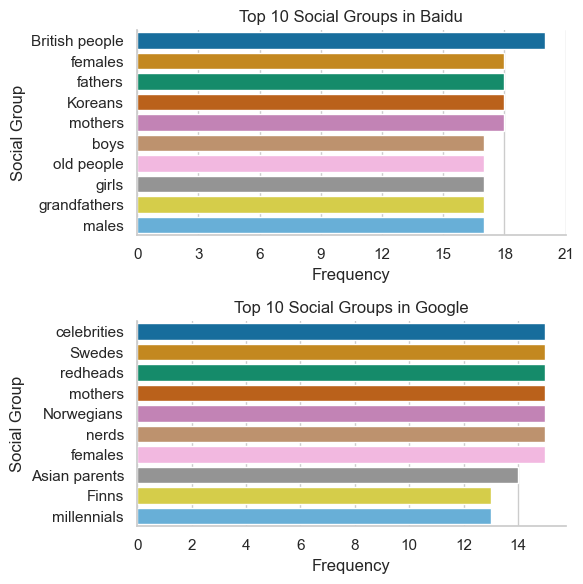

In [206]:
# Revised function to create a more refined and flatter horizontal bar plot without borders
def create_refined_horizontal_bar_plot(data, title, ax):
    sns.barplot(x=data.values, y=data.index, palette=sns.color_palette("colorblind"), ax=ax)
    ax.set_title(title)
    ax.set_ylabel('Social Group')
    ax.set_xlabel('Frequency')
    ax.xaxis.set_major_locator(mtick.MaxNLocator(integer=True))
    sns.despine(ax=ax)  # Remove the top and right spines

# Create figure with two subplots for horizontal layout, adjusted for a flatter look
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 6))  # Adjusted size for a flatter appearance

# Plotting for Baidu
create_refined_horizontal_bar_plot(top_10_baidu, 'Top 10 Social Groups in Baidu', axes[0])

# Plotting for Google

create_refined_horizontal_bar_plot(top_10_google, 'Top 10 Social Groups in Google', axes[1])

plt.tight_layout()
plt.show()

### unresponded query

/Users/gengliu/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/gengliu/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/gengliu/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/gengliu/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Catego

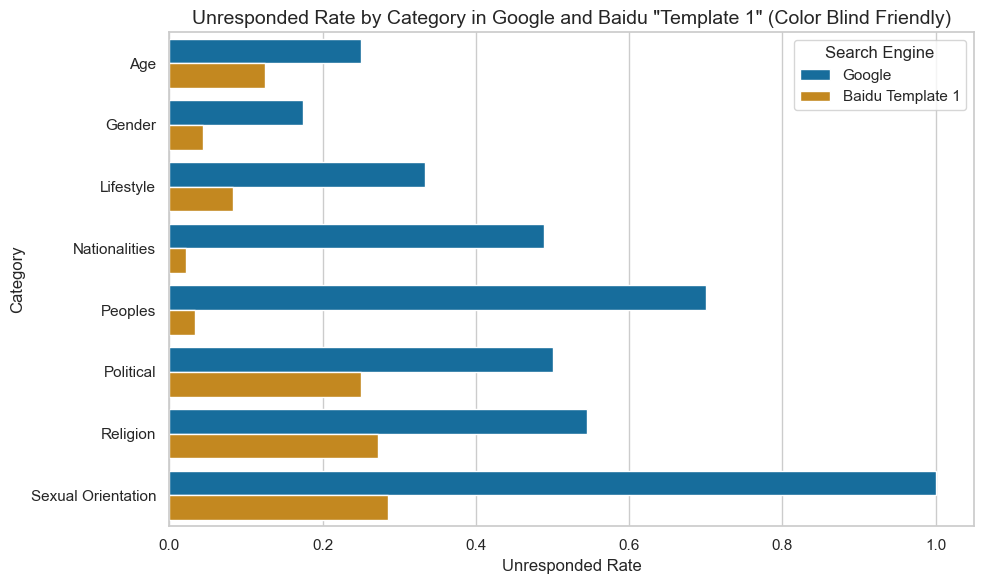

In [207]:
# Read in the data
baidu = pd.read_csv("data/baidu.csv")
google = pd.read_csv("data/google.csv")

# Identifying unresponded queries for Google
unresponded_queries_google = google[google['suggestion'].isnull()]

# Identifying unresponded queries for Baidu 'Template 1'
df_template_1 = baidu[baidu.template_match == "template 1"]
unresponded_queries_baidu_template_1 = df_template_1[df_template_1['suggestion'].isna()]

# Calculating unresponded rates for Google and Baidu
def calculate_unresponded_rates(df, unresponded_df):
    unique_queries_per_category = df.groupby('category')['query'].nunique()
    unresponded_queries_per_category = unresponded_df.groupby('category').size()
    unresponded_rate_per_category = (unresponded_queries_per_category / unique_queries_per_category).fillna(0)
    return pd.DataFrame({
        'Total Unique Queries': unique_queries_per_category,
        'Unresponded Queries': unresponded_queries_per_category,
        'Unresponded Rate': unresponded_rate_per_category
    }).reset_index()

# Google and Baidu unresponded rates DataFrames
google_unresponded_rate_df = calculate_unresponded_rates(google, unresponded_queries_google)
baidu_unresponded_rate_df = calculate_unresponded_rates(df_template_1, unresponded_queries_baidu_template_1)

# Preparing the data for seaborn plot
google_unresponded_rate_df['Search Engine'] = 'Google'
baidu_unresponded_rate_df['Search Engine'] = 'Baidu Template 1'
combined_df = pd.concat([google_unresponded_rate_df, baidu_unresponded_rate_df])

# Plotting using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=combined_df, x='Unresponded Rate', y='category', hue='Search Engine', palette='colorblind')
plt.title('Unresponded Rate by Category in Google and Baidu "Template 1" (Color Blind Friendly)', fontsize=14)
plt.xlabel('Unresponded Rate')
plt.ylabel('Category')
plt.tight_layout()
plt.show()


### no group in the suggestion
### changed format in the suggestion

/Users/gengliu/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/gengliu/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/gengliu/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/gengliu/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Catego

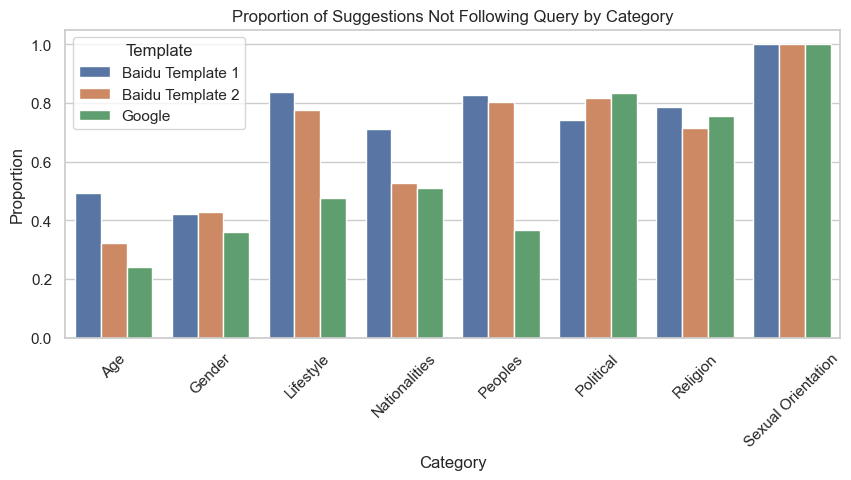

/Users/gengliu/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/gengliu/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/gengliu/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/gengliu/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Catego

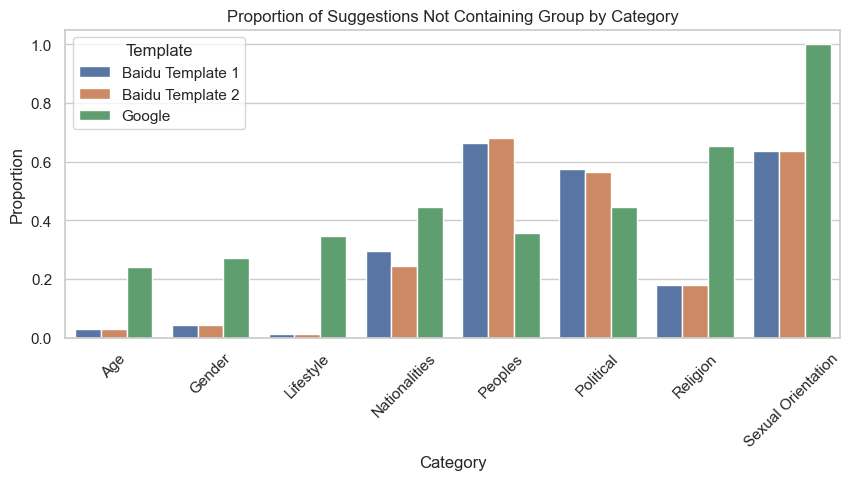

In [208]:
# Read in the data
baidu_template_1 = baidu[baidu.template_match == "template 1"]
baidu_template_2 = baidu[baidu.template_match == "template 2"]
# Step 5: Calculate Inverse Proportions for Each Category
def calculate_category_inverse_proportions(grouped_data):
    proportions = {}
    for category, group in grouped_data:
        total = len(group)
        not_follow_query = (total - group['suggestion_starts_with_query'].sum()) / total
        not_contain_group = (total - group['group_in_suggestion'].sum()) / total
        proportions[category] = {'Not Follow Query': not_follow_query, 'Not Contain Group': not_contain_group}
    return proportions

# Group the data by category for each template and search engine
grouped_baidu_template_1 = baidu_template_1.groupby('category')
grouped_baidu_template_2 = baidu_template_2.groupby('category')
grouped_google = google.groupby('category')

# Calculate the inverse proportions
inverse_proportions_baidu_template_1 = calculate_category_inverse_proportions(grouped_baidu_template_1)
inverse_proportions_baidu_template_2 = calculate_category_inverse_proportions(grouped_baidu_template_2)
inverse_proportions_google = calculate_category_inverse_proportions(grouped_google)

# Prepare the data for plotting
plot_data = []
for category in inverse_proportions_baidu_template_1:
    plot_data.append({
        'Category': category,
        'Template': 'Baidu Template 1',
        'Not Follow Query': inverse_proportions_baidu_template_1[category]['Not Follow Query'],
        'Not Contain Group': inverse_proportions_baidu_template_1[category]['Not Contain Group']
    })

for category in inverse_proportions_baidu_template_2:
    plot_data.append({
        'Category': category,
        'Template': 'Baidu Template 2',
        'Not Follow Query': inverse_proportions_baidu_template_2[category]['Not Follow Query'],
        'Not Contain Group': inverse_proportions_baidu_template_2[category]['Not Contain Group']
    })

for category in inverse_proportions_google:
    plot_data.append({
        'Category': category,
        'Template': 'Google',
        'Not Follow Query': inverse_proportions_google[category]['Not Follow Query'],
        'Not Contain Group': inverse_proportions_google[category]['Not Contain Group']
    })

df_plot = pd.DataFrame(plot_data)

# Plot the data
plt.figure(figsize=(10, 4))
sns.barplot(x='Category', y='Not Follow Query', hue='Template', data=df_plot)
plt.title('Proportion of Suggestions Not Following Query by Category')
plt.ylabel('Proportion')
plt.xlabel('Category')
plt.xticks(rotation=45)
plt.legend(title='Template')
plt.show()

plt.figure(figsize=(10, 4))
sns.barplot(x='Category', y='Not Contain Group', hue='Template', data=df_plot)
plt.title('Proportion of Suggestions Not Containing Group by Category')
plt.ylabel('Proportion')
plt.xlabel('Category')
plt.xticks(rotation=45)
plt.legend(title='Template')
plt.show()


# RQ2: What is the sentiment of search engine completion on Google vs Baidu?

In [209]:
## dataframe {engine, category, group, % negative}

## sns.boxplot
## hue = engine
## x = category
## y = % negative

## kruskal-wallis test?